# Subtargets

To analyze the SSCx circuit topologically, we want to compare columnar targets
distributed across the circuit's flatmap. Such columns are comparable to the
microcircuit columns that we have studied before. Becauseathe term *target* 
alreadt means a lot of things, we shall call such columnar targets as *subtargets*,
reserving the term *target* to name any group of cells.

In this study, we discuss the development of a tool to generate such subtargets.


**NOTE** This is a work-in-progress. In its final form, this notebook, and others
like it are intended to be an scientific introduction as well as documentation
to the code in this repository.


In [3]:
#load tools to compose an article of analysis.

import os
import importlib
from importlib import reload
from pathlib import Path
import logging

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sbn

from scarpy.document import article

tessellate = importlib.import_module("tessellate")
hexgrid = importlib.import_module("hexgrid")

LOG = logging.getLogger("Tessellate-2D with triangles.")
LOG.setLevel(os.environ.get("LOGLEVEL", "INFO"))


(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

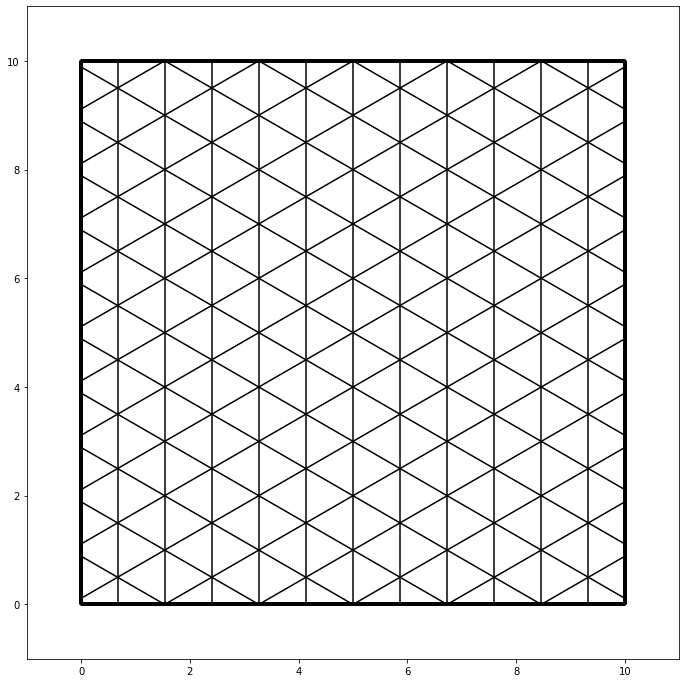

In [4]:
reload(tessellate)
tritille = tessellate.TriTille(1.,  origin=np.array([5., 5.]), angle=0.)

figure = plt.figure(figsize=(12,12))
axes = figure.add_subplot(111, aspect=1.)

tritille.display(10, origin=np.array([0., 0.]), hexgrid=True,
                 graphic=(figure, axes))

# A mock circuit

We will compute sub-targets for a BluePy circuit.
However, for the purposes of development, we will use the flatmap NRRD and 
a CSV providing the circuit's cells as a data-frame.
Both these required artefacts will be loaded using a mock-circuit 
that quacks like a BluePy circuit.
As a result code in the subsequent sections will thus apply to a BluePy circuit.

In [15]:
from voxcell.nexus.voxelbrain import Atlas

class BlueishCircuit:
    """A dynamic mock circuit."""
    class Cells:
        """..."""
        def __init__(self, path):
            """..."""
            self._cells = pd.read_csv(path)
            self._cells.index = pd.Index(range(1, self._cells.shape[0] + 1))
        
        def get(self, group=None, properties=None):
            """..."""
            assert group in (None, "Mosaic"), group
            return (self._cells[properties] if properties is not None
                    else self._cells)
        
        
    class Connectome:
        """..."""
        def __init__(self, path):
            """..."""
            raise NotImplementedError
        

    def __init__(self, path_atlas, path_cells, path_connectome=None):
        """..."""
        self.atlas = Atlas.open(path_atlas)
        self.cells = BlueishCircuit.Cells(path_cells)
        if path_connectome:
            self._connectome = Connectome(path_connectome)


In [16]:
#point these paths to your folders

scratch = Path("/Users/vishalsoodmuchu/work/bbp/work/scratch")
circuit = BlueishCircuit(path_atlas=(scratch/"P14-MEAN").as_posix(),
                         path_cells=(scratch/"sscx_cells.csv").as_posix())


# Subtarget Distribution 

We use our tiling tool to generate subtargets and analyze them.

In [7]:
reload(hexgrid)
sample_frac = 1.e-3
radius, subtargets = hexgrid.generate_subtargets(circuit, size=30000,
                                                 sample=sample_frac)

In [8]:
print(radius, subtargets.shape[0])
subtargets.head()

5.5177001953125 3985


,i,j,gid,x,y
subtarget,,,,,
R11;C4,-12,21,3930280,43.006217,91.042053
R11;C4,-12,21,2005487,43.006217,91.042053
R11;C4,-12,21,1728800,43.006217,91.042053
R11;C4,-12,21,3758196,43.006217,91.042053
R11;C4,-12,21,3176042,43.006217,91.042053


In [9]:
subtarget_sizes = subtargets.groupby("subtarget").size() / sample_frac
print(subtarget_sizes.agg(["min", "mean", "std", "median", "mad", "max"]))

min        1000.000000
mean      29962.406015
std       15540.955674
median    34000.000000
mad       12839.957035
max       62000.000000
dtype: float64


In [10]:
subtargets.gid.min()

785

## Using a config

We can use a configuration to define subtargets.

In [39]:
reload(hexgrid)
config = {"paths": {"circuit": {"Bio_M": circuit}}}

subtarget_config = hexgrid.SubtargetConfig(config)

sample_frac = 1.e-4

subtargets_wide = (hexgrid.define_subtargets(subtarget_config,
                                             sample_frac=sample_frac,
                                             format="wide"))

In [40]:
print(subtargets_wide.shape)
subtargets_wide.head()

(131,)


circuit  subtarget  flat_x      flat_y   
Bio_M    R10;C10    86.260021   74.703369                 [125, 134, 221, 377]
         R10;C18    155.268037  74.703369                            [59, 165]
         R10;C4     34.504008   74.703369                                [113]
         R10;C5     43.130010   74.703369                       [31, 138, 169]
         R10;C6     51.756012   74.703369    [15, 41, 116, 171, 241, 313, 389]
Name: gids, dtype: object

In [ ]:
reload(hexgrid)
subtargets_long = hexgrid.define_subtargets(subtarget_config,
                                            sample_frac=sample_frac,
                                            format="long")
subtargets_long.head()

In [32]:
print(subtargets_long.head())

def enlist(group):
    row = pd.Series({"flat_x": np.mean(group["flat_x"]),
                     "flat_y": np.mean(group["flat_y"])})
    row["gid"] = list(group["gid"].values)
    return row


q = subtargets_long.groupby(["subtarget", "flat_x", "flat_y"]).apply(enlist)["gid"]
q.head()


              i     j  gid     flat_x     flat_y
subtarget                                       
R12;C6    -12.0  24.0  117  52.057937  90.166992
R12;C6    -12.0  24.0  245  52.057937  90.166992
R11;C5    -11.0  22.0  120  47.719776  82.653076
R11;C5    -11.0  22.0  226  47.719776  82.653076
R12;C7    -11.0  25.0   98  60.734260  90.166992


subtarget  flat_x      flat_y  
R10;C10    86.763229   75.13916         [53, 91, 239, 272, 325]
R10;C11    95.439552   75.13916                 [234, 266, 352]
R10;C18    156.173812  75.13916                      [328, 350]
R10;C19    164.850135  75.13916    [19, 93, 192, 278, 366, 395]
R10;C20    173.526457  75.13916                      [111, 349]
Name: gid, dtype: object

In [51]:
from scripts import read_config

In [54]:
reload(hexgrid)
reload(read_config)
path_config = "../../../reduced_example_config.json"
config = hexgrid.SubtargetConfig(path_config, reader=read_config)
config.output

('/Users/vishalsoodmuchu/work/bbp/work/.bbpcode/proj83/topological-analysis-of-subvolumes/hexgrid/test/notebooks/scripts/results/topological_sampling.h5',
 'subtargets')

In [53]:
config._config["paths"]

{'circuit': {'Bio_M': '/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/CircuitConfig'},
 'defined_columns': ('/Users/vishalsoodmuchu/work/bbp/work/.bbpcode/proj83/topological-analysis-of-subvolumes/hexgrid/test/notebooks/scripts/results/topological_sampling.h5',
  'subtargets'),
 'neurons': ('/Users/vishalsoodmuchu/work/bbp/work/.bbpcode/proj83/topological-analysis-of-subvolumes/hexgrid/test/notebooks/scripts/results/topological_sampling.h5',
  'neurons'),
 'tgt_evaluations': ('/Users/vishalsoodmuchu/work/bbp/work/.bbpcode/proj83/topological-analysis-of-subvolumes/hexgrid/test/notebooks/scripts/results/topological_sampling.h5',
  'subtarget_quality'),
 'connection_matrices': ('/Users/vishalsoodmuchu/work/bbp/work/.bbpcode/proj83/topological-analysis-of-subvolumes/hexgrid/test/notebooks/scripts/results/topological_sampling.h5',
  'con_mats/con_mats_original'),
 'randomized_matrices': ('/Users/vishalsoodmuchu/work/bbp/work/.bbpcode/proj83/topological-analysis-of-subvolumes/hexgr

In [17]:
positions = hexgrid.get_cell_positions(circuit)
print(positions.shape)
positions.head()

(4234929, 3)


,x,y,z
gid,,,
1,4877.122429,-668.324217,-1696.124733
2,5383.917646,-546.443089,-2318.223122
3,5038.520009,-2747.467238,-2582.717297
4,4873.650857,-2615.218299,-2412.265532
5,4470.542212,561.526704,-1271.187550


In [18]:
flatmap = hexgrid.get_flatmap(circuit, positions)
print(flatmap.shape)
flatmap.head()

(3979592, 2)


,x,y
gid,,
1,36,52
2,47,48
3,24,21
4,22,24
5,39,73


In [19]:
hexmap = tritille.bin_hexagonally(flatmap, use_columns_row_indexing=False)
print(hexmap.shape)
hexmap.head()

(3979592, 2)


,i,j
gid,,
1,-9,78
2,-1,86
3,2,35
4,-2,37
5,-20,103


In [20]:
grid = tritille.locate_grid(hexmap)
print(grid.shape)
grid.head()

(3298, 2)


,,x,y
i,j,,
-9,78,69.755753,53.5
-1,86,83.612159,53.5
2,35,42.042940,26.5
-2,37,40.310889,29.5
-20,103,81.880109,71.5


In [21]:
annotation = tritille.annotate(grid, using_column_row=True)
print(annotation.shape)
annotation.head()

(3298,)


i    j  
-9   78     R29;C34
-1   86     R29;C42
 2   35     R11;C18
-2   37     R13;C17
-20  103    R41;C41
dtype: object

In [22]:
gids_by_gridpoint = hexmap.reset_index().set_index(["i", "j"])
print(gids_by_gridpoint.shape)
gids_by_gridpoint.head()

(3979592, 1)


,,gid
i,j,
-9,78,1
-1,86,2
2,35,3
-2,37,4
-20,103,5


In [23]:
annotated_grid = grid.assign(subtarget=annotation.loc[grid.index])
print(annotated_grid.shape)
annotated_grid.head()

(3298, 3)


,,x,y,subtarget
i,j,,,
-9,78,69.755753,53.5,R29;C34
-1,86,83.612159,53.5,R29;C42
2,35,42.042940,26.5,R11;C18
-2,37,40.310889,29.5,R13;C17
-20,103,81.880109,71.5,R41;C41


In [24]:
q = gids_by_gridpoint.join(annotated_grid).reset_index().set_index("subtarget")
print(q.shape)
q.head()

(3979592, 5)


,i,j,gid,x,y
subtarget,,,,,
R55;C17,-65,100,9210,40.310889,92.5
R55;C17,-65,100,79774,40.310889,92.5
R55;C17,-65,100,98105,40.310889,92.5
R55;C17,-65,100,124131,40.310889,92.5
R55;C17,-65,100,183562,40.310889,92.5


In [25]:
q.gid.agg(["mean", "min", "median", "max", "std", "mad"])

mean      2.119484e+06
min       1.000000e+00
median    2.132972e+06
max       4.234929e+06
std       1.225370e+06
mad       1.062646e+06
Name: gid, dtype: float64